# Demographics Data

Marketing Database.

Source: Impact Resources, Inc., Columbus, OH (1987). 

A total of N=9409 questionnaires containg 502 questions were filled out by shopping mall customers in the San Francisco Bay area. 

The dataset is an extract from this survey. It consists of 14 demographic attributes. The dataset is a good mixture of categorical and continuos variables with a lot of missing data. This is characteristic 
for data mining applications. 

Variables:

|         |                                                                  |
|---------|------------------------------------------------------------------|
|income   |ANNUAL INCOME OF HOUSEHOLD<br>(PERSONAL INCOME IF SINGLE)         |
|sex      |SEX                                                               |
|mar-stat |MARITAL STATUS                                                    |
|age      |AGE                                                               |
|edu      |EDUCATION                                                         |
|occup    |OCCUPATION                                                        |
|yrs-BA   |HOW LONG HAVE YOU LIVED IN THE<br>SAN FRAN./OAKLAND/SAN JOSE AREA?|
|mar-dlinc|DUAL INCOMES (IF MARRIED)                                         |
|num-hsld |PERSONS IN YOUR HOUSEHOLD                                         |
|children |PERSONS IN HOUSEHOLD UNDER 18                                     |
|hsld-stat|HOUSEHOLDER STATUS                                                |
|typ-home |TYPE OF HOME                                                      |
|ethnic   |ETHNIC CLASSIFICATION                                             |
|lang     |WHAT LANGUAGE IS SPOKEN MOST<br>OFTEN IN YOUR HOME?               |

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Demographis.txt", sep=';')
df.head(2)

,income,sex,mar-stat,age,edu,occup,yrs-BA,mar-dlinc,num-hsld,children,hsld-stat,typ-home,ethnic,lang
0,"$75,000 or more",Female,Married,45 thru 54,1 to 3 years of college,Homemaker,More than ten years,No,Three,None,Own,House,White,NaN
1,"$75,000 or more",Male,Married,45 thru 54,College graduate,Homemaker,More than ten years,No,Five,Two,Own,House,White,English


### Treat Missing Values

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
# replace missing values with most frequent observations
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

### Treat Ordered Categorical Features

In [5]:
# Convert ordered categorical (ordinal) features to quantitative.
# The values of this type of variable are often represented
# as contiguous integers (1-N), but I prefer 'natural' values.
# It doesn't affect the result, but the plots are easier to read
income_cats = {
    'Less than $10,000':  5000,  '$10,000 to $14,999': 12500,
    '$15,000 to $19,999': 17500, '$20,000 to $24,999': 22500,
    '$25,000 to $29,999': 27500, '$30,000 to $39,999': 35000,
    '$40,000 to $49,999': 45000, '$50,000 to $74,999': 62500,
    '$75,000 or more': 100000}

age_cats = {
    '14 thru 17': 15, '18 thru 24': 21, '25 thru 34': 30,
    '35 thru 44': 40, '45 thru 54': 50, '55 thru 64': 60,
    '65 and Over': 70}

yrs_BA_cats = {
    'Less than one year': 0.5, 'One to three years': 2,
    'Four to six years': 5,    'Seven to ten years': 8,
    'More than ten years': 15}

num_hsld_cats = {
    'One': 1, 'Two': 2,   'Three': 3, 'Four': 4, 'Five': 5,
    'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine or more': 10}

children_cats = {
    'None': 0, 'One': 1, 'Two': 2,   'Three': 3, 'Four': 4,
    'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine or more': 10}

# do replacement
df.replace({
    'income': income_cats,
    'age': age_cats,
    'yrs-BA': yrs_BA_cats,
    'num-hsld': num_hsld_cats,
    'children': children_cats
}, inplace=True)

### Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
target = 'occup'
features = [
    'income', 'sex', 'mar-stat', 'age', 'edu', 'yrs-BA', 'mar-dlinc',
    'num-hsld', 'children', 'hsld-stat', 'typ-home', 'ethnic', 'lang']
cat_features = [
    'sex', 'mar-stat', 'mar-dlinc', 'edu',
    'hsld-stat', 'ethnic', 'lang', 'typ-home']

X, y = df[features].values, df[target].values

# PAGE 379. We randomly divided the data into a training set (80%) 
#           and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

## Base Model

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [9]:
# PAGE 379. ...the null rate of 69% obtained by predicting the most
#           numerous class Prof/Man (Professional/Managerial).
dummy_clf = DummyClassifier(
    strategy='most_frequent'
).fit(X_train, y_train)
y_test_hat = dummy_clf.predict(X_test)
dummy_error_rate = 1 - accuracy_score(y_test, y_test_hat)
print(f'The null error rate {dummy_error_rate:.2f}')

The null error rate 0.69


## Boosting over Decision Trees

In [13]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import confusion_matrix

In [11]:
# CatBoost uses the indices of categorical features
cat_features_idx = [features.index(f) for f in cat_features]

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features_idx)

eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features_idx)

In [12]:
model = CatBoostClassifier(
    iterations=350,
    learning_rate=0.035,
    loss_function='MultiClass',
    eval_metric='Accuracy'
).fit(
    train_dataset,
    use_best_model=True,
    eval_set=eval_dataset,
    verbose=False,
    plot=False  # set it True to track training progress
)

### Model Performance

In [33]:
# PAGE 379. The overall error rate is 42.5% ... The four best predicted
#           classes are seen to be Retired, Student, Prof/Man, and Homemaker.
y_test_hat = model.predict(X_test)
overall_error_rate = 1 - accuracy_score(y_test, y_test_hat)
occupations = list(set(y))
cm = confusion_matrix(y_test, y_test_hat, labels=occupations)
occup_error_rates = 1 - cm.diagonal()/cm.sum(axis=1)
errors = sorted(zip(occup_error_rates, occupations))

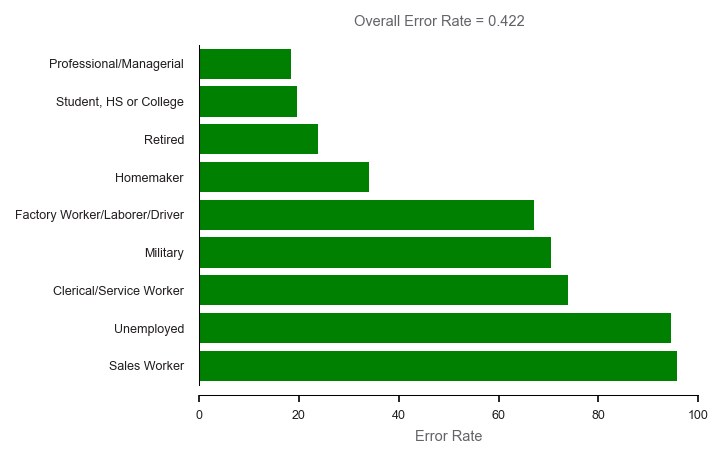

In [34]:
# PAGE 381. FIGURE 10.22. Error rate for each occupation in the demographics
#           data.
yticks = np.arange(len(errors))
yticklabels = [e[1] for e in errors][::-1]
bars_sizes = [100*e[0] for e in errors][::-1]

fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='green')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, 8.5])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY1)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
ax.text(31, 9, f'Overall Error Rate = {overall_error_rate:.3f}',
        color=GRAY4, fontsize=7)
_ = ax.set_xlabel('Error Rate', color=GRAY4, fontsize=7)

### Relative Importance of the Predictors

In [36]:
# PAGE 380. Figure 10.23 shows the relative predictor variable
#           importances as averaged over all classes (10.46).
importance = np.array(model.get_feature_importance())
max_importance = np.max(importance)
relative_importance = sorted(zip(100*importance/max_importance, features))

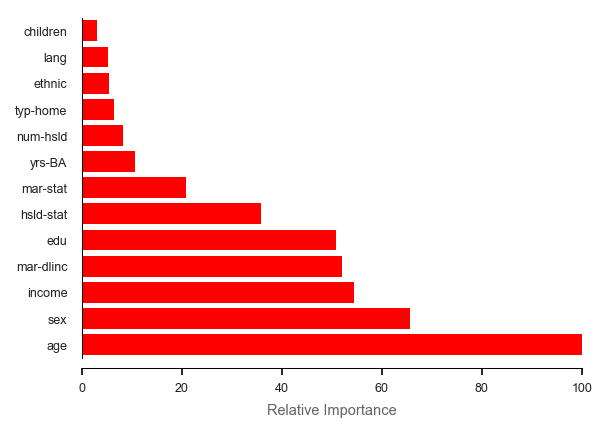

In [39]:
# PAGE 381. FIGURE 10.23. Relative importance of the predictors as
#           averaged over all classes for the demographics data.
yticks = np.arange(len(relative_importance))
yticklabels = [ri[1] for ri in relative_importance][::-1]
bars_sizes = [ri[0] for ri in relative_importance][::-1]

fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, len(relative_importance) - 0.5])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY1)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
_ = ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)